# Problem B1: First autocorrelation inequality
For any function $f:\mathbb{R} \rightarrow \mathbb{R}$, define the *autoconvolution* of $f$, written $f*f$, as
$$f*f (t) := \int_\mathbb{R} f(t-x) f(x)\ dx.$$

Let $C_1$ denote the largest constant for which one has
\begin{equation}
 \max_{-1/2 \leq t \leq 1/2} f*f(t) \geq C_1 \left(\int_{-1/4}^{1/4} f(x)\ dx\right)^2
\end{equation}
for all non-negative $f: \mathbb{R} \rightarrow \mathbb{R}$.  This problem arises in additive combinatorics, relating to the size of Sidon sets.  It is currently known that
$$ 1.28 \leq C_1 \leq 1.5098$$
with the lower bound proven by [Cloninger and Steinerberger (2017)](https://www.ams.org/journals/proc/2017-145-08/S0002-9939-2017-13690-9/S0002-9939-2017-13690-9.pdf) and the upper bound achieved by [Matolcsi and Vinuesa (2010)](https://www.sciencedirect.com/science/article/pii/S0022247X10006001) via a step function construction. AlphaEvolve found a step function with 600 equally-spaced intervals on $[-1/4,1/4]$ that gives a better upper bound of $C_1 \leq 1.5053$.

## Compute the step function, the integral, and the autoconvolution

For step func. 
$$f(x) = \sum_{i=0}^{P-1} h_i \mathbf{1}_{[x_i, x_{i+1})}(x)$$  
where
$$ x_i = -\frac{1}{4} + \frac{i}{2P}, \text{ and heights } h_i \ge 0:$$
$$
\begin{aligned}
% Integral
\text{Integral:}\quad \int_{-1/4}^{1/4} f(x) \,dx &= \frac{1}{2P} \sum_{i=0}^{P-1} h_i
\\[2ex]
% Autoconvolution
\text{Autoconv. knots:}\quad (f*f)(t_m) &= 
\begin{cases} 
0 & \text{if } m=0 \text{ or } m=2P \\
\frac{1}{2P} \sum_{k=\max(0, m-P)}^{\min(P-1, m-1)} h_k h_{m-1-k} & \text{if } 1 \le m \le 2P-1
\end{cases}
\\[0.5ex]
&\quad \text{where } t_m = -\frac{1}{2} + \frac{m}{2P} \quad (m=0, \dots, 2P).
\end{aligned}
$$

## The structure of the optimization problem

Let $f_h$ denote the step function with heights $h$. We're trying to optimize the function:
\begin{align*}
\mathrm{minimize} &\; L(h) := \max_{-1/2\leq t \leq 1/2} (f_h\ast f_h)(t) \\
\text{subject to } &\; \int_{-1/4}^{1/4} f_h(t) dt = \frac{\mathbf{1}^T h}{2P} = 1 \\
&\; h \geq 0.
\end{align*}
This is a nonsmooth qudaratic optimization problem over a simplex.

Note that this is not convex: set $P=2$ and $h_0+h_1=2P=4$. The objective is
$$
\frac{1}{2P}\max(h_0^2, 2h_0h_1, h_1^2)
$$
We can parameterize the feasible region by $h_0 \in [0,4]$. Then there is a region where $2h_0h_1 = 2h_0(4-h_0)$ attains the max and the function becomes concave.


## Plot the step function and the autoconvolution

--- Function Details (P=600) ---
Integral of f(x): 0.245139
Max value of autoconvolution (f*f)(t): 0.123816
Ratio max(f*f) / (integral(f))^2: 2.060408


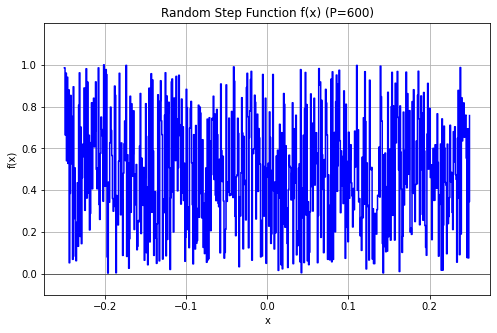

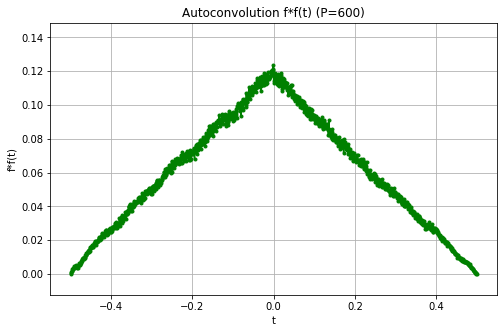

In [1]:
# script assumes 'compute_integral_of_step_function' and 'compute_autoconvolution_values'
# (from your previous code block) are already defined and executable in the notebook.
from utils import *

# --- main script logic ---
P_val = 600  # number of pieces for the step function
f_interval = (-0.25, 0.25) # interval for f(x)

f_x_min, f_x_max = f_interval
f_delta_x = (f_x_max - f_x_min) / P_val

# 1. sample random heights (non-negative)
# using float64 for precision, requires_grad=False for plotting/evaluation only
height_values = torch.rand(P_val, dtype=torch.float64) 
# for more structured/sparse functions, you could try:
# height_values = torch.abs(torch.randn(P_val, dtype=torch.float64)) * (torch.rand(P_val, dtype=torch.float64) > 0.7).double()


# 2. compute integral of f(x)
integral_value = compute_integral_of_step_function(height_values, f_delta_x)

# 3. compute autoconvolution (f*f)(t) knot values
# (2*P_val + 1) values for t_m from 2*f_x_min to 2*f_x_max
autoconv_knot_vals = compute_autoconvolution_values(height_values, f_delta_x, P_val)
max_autoconv_value = torch.max(autoconv_knot_vals)

# 4. calculate the ratio for C1 estimate
# (max f*f(t)) / (integral f(x) dx)^2
if integral_value.item() == 0:
    c1_ratio = float('inf') if max_autoconv_value.item() > 0 else 0.0 # handle division by zero
else:
    c1_ratio = max_autoconv_value / (integral_value**2)

print(f"--- Function Details (P={P_val}) ---")
# print(f"Heights (h_i, first 10): {height_values.numpy()[:10]}") # uncomment if you want to see heights
print(f"Integral of f(x): {integral_value.item():.6f}")
print(f"Max value of autoconvolution (f*f)(t): {max_autoconv_value.item():.6f}")
print(f"Ratio max(f*f) / (integral(f))^2: {c1_ratio.item():.6f}")


# 5. plotting
# plot f(x)
plot_rendered_step_function(height_values.numpy(), f_interval, title=f"Random Step Function f(x) (P={P_val})")

# plot f*f(t)
# autoconvolution is defined on [2*f_x_min, 2*f_x_max]
conv_t_knots = np.linspace(2 * f_x_min, 2 * f_x_max, 2 * P_val + 1, dtype=float)
plot_rendered_convolution(conv_t_knots, autoconv_knot_vals.numpy(), title=f"Autoconvolution f*f(t) (P={P_val})")



## Plotting Google's solution

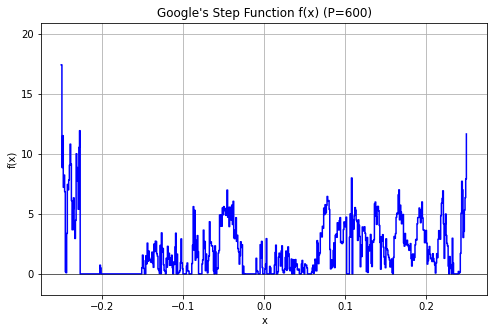

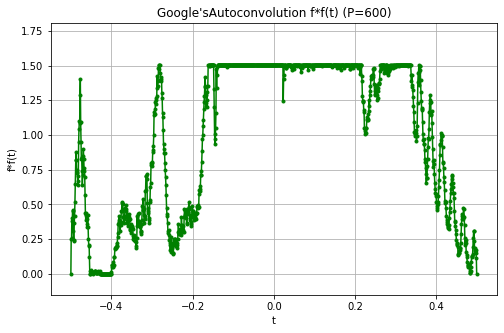

In [2]:
# Also plot google's solution
h_params_google = return_height_params_google_simplex()
autoconv_knot_vals_google = compute_autoconvolution_values(h_params_google, f_delta_x, P_val)
max_autoconv_value_google = torch.max(autoconv_knot_vals_google)

plot_rendered_step_function(h_params_google.detach().numpy(), f_interval, title=f"Google's Step Function f(x) (P={P_val})")
plot_rendered_convolution(conv_t_knots, autoconv_knot_vals_google.detach().numpy(), title=f"Google'sAutoconvolution f*f(t) (P={P_val})")

## Algorithm 1: (Projected) Polyak subgradient method

The algorithm 
$$
h_+ = \mathrm{proj}_{\Delta_{2P}}\left(h - \frac{L(h) - L^*}{\| \nabla L(h) \|^2} \nabla L(h)\right)
$$
where $L^*$ is the target loss.

There is a subtlety here: we don't know what the optimal value is.

### Polyak with Random initialization

Iteration 0: loss = 2.0015867, step_size = 73.0661659, grad_norm = 0.0824403, min_loss_found_polyak = 2.001587
Best loss found: 1.5502576407380302


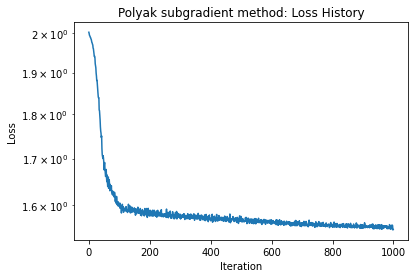

In [3]:
P_val = 600
# Initialize random height parameters
h_params_polyak = torch.rand(P_val, dtype=torch.float64)
h_params_polyak.requires_grad = True
# Define the projection and loss
def projection(x): 
    return projection_simplex_pytorch(x, 2*P_val)
h_params_polyak.data = projection(h_params_polyak.data)
loss_fn = constrained_loss(P_val)

# Setting up history
if 'history_polyak_constrained_random' not in locals():
    history_polyak_constrained_random = {}
else:
    h_params_polyak.data = history_polyak_constrained_random['best_h_params'].data.clone()

# Setting up parameters for Polyak
max_iter = 1000
target_loss = 1.505
print_every = 1000

history_polyak_constrained_random = polyak_subgradient_method(h_params_polyak,loss_fn, max_iter, target_loss, print_every, history_polyak_constrained_random, projection)
print("Best loss found:", history_polyak_constrained_random['min_loss_found'])
# semilogy plot of loss history
plt.semilogy(history_polyak_constrained_random['loss_history'])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Polyak subgradient method: Loss History")
plt.show()


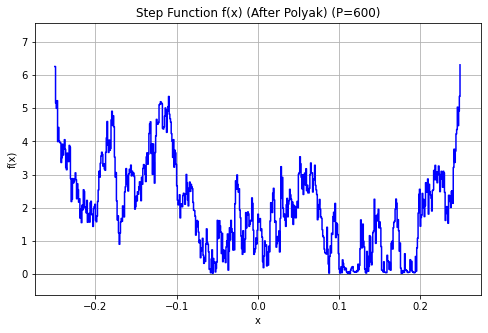

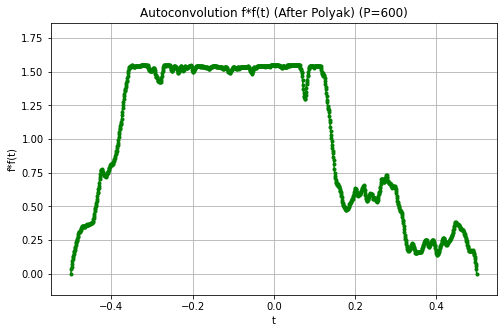

In [4]:
autoconv_knot_vals_polyak = compute_autoconvolution_values(history_polyak_constrained_random['best_h_params'], f_delta_x, P_val)
max_autoconv_value_polyak = torch.max(autoconv_knot_vals_polyak)

plot_rendered_step_function(history_polyak_constrained_random['best_h_params'].detach().numpy(), f_interval, title=f"Step Function f(x) (After Polyak) (P={P_val})")
plot_rendered_convolution(conv_t_knots, autoconv_knot_vals_polyak.detach().numpy(), title=f"Autoconvolution f*f(t) (After Polyak) (P={P_val})")

torch.set_printoptions(precision=16, sci_mode=False)  # global setting
# need 16 digits of precision for the loss for the print statement to be correct

### Polyak started at the Google solution 

Iteration 0: loss = 1.5052943, step_size = 0.0002117, grad_norm = 0.1047444, min_loss_found_polyak = 1.505294
Best loss found (Google solution initialization): 1.505293369293213


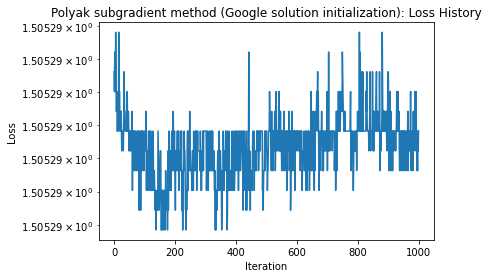

In [5]:
P_val = 600
h_params_polyak_google = h_params_google.data.detach().clone() # initialize variable at google's solution.
h_params_polyak_google.requires_grad = True
# Define the projection and loss
def projection(x): 
    return projection_simplex_pytorch(x, 2*P_val)
h_params_polyak_google.data = projection(h_params_polyak_google.data)
loss_fn = constrained_loss(P_val)

# Setting up history
if 'history_polyak_constrained_google' not in locals():
    history_polyak_constrained_google = {}
else:
    h_params_polyak_google.data = history_polyak_constrained_google['best_h_params'].data.clone()

max_iter = 1000
target_loss_google = 1.505292
print_every = 1000

history_polyak_constrained_google = polyak_subgradient_method(h_params_polyak_google, loss_fn, max_iter, target_loss_google, print_every, history_polyak_constrained_google, projection)

print("Best loss found (Google solution initialization):", history_polyak_constrained_google['min_loss_found'])

# semilogy plot of loss history
plt.semilogy(history_polyak_constrained_google['loss_history'])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Polyak subgradient method (Google solution initialization): Loss History")
plt.show()


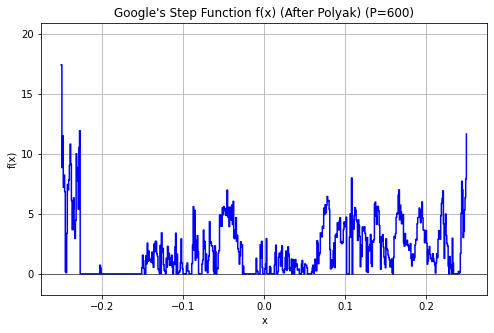

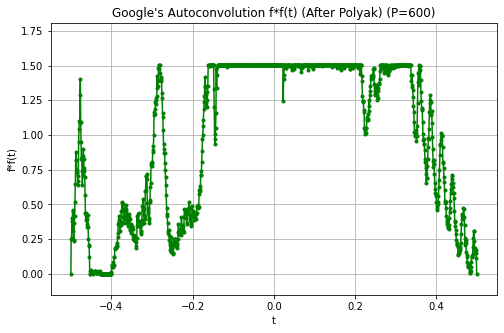

best_height_params_polyak_google tensor([   17.4101600646972656,     8.8549089431762695,    11.5087823867797852,
            7.2115802764892578,     8.2294750213623047,     6.8511590957641602,
            0.1715504229068756,     0.0950221568346024,     3.3703746795654297,
            7.4499421119689941,     6.9981336593627930,     7.8191924095153809,
            9.0487995147705078,    10.8042201995849609,     9.1564779281616211,
            6.1059794425964355,     3.6775650978088379,     5.3863077163696289,
            6.3343515396118164,     3.6684074401855469,     2.9492917060852051,
            4.4549655914306641,    10.0047130584716797,     8.8576641082763672,
            7.7132811546325684,     5.3816161155700684,    10.5341558456420898,
           11.9250411987304688,     0.0000045896726988,     0.0000061654700403,
            0.0000081271546151,     0.0000063876977947,     0.0000052476311794,
            0.0000021862222184,     0.0000075314937931,     0.0000053697449403,
       

In [6]:
# Also plot google's solution
autoconv_knot_vals_google_polyak = compute_autoconvolution_values(history_polyak_constrained_google['best_h_params'], f_delta_x, P_val)
max_autoconv_value_google_polyak = torch.max(autoconv_knot_vals_google_polyak)

plot_rendered_step_function(history_polyak_constrained_google['best_h_params'].detach().numpy(), f_interval, title=f"Google's Step Function f(x) (After Polyak) (P={P_val})")
plot_rendered_convolution(conv_t_knots, autoconv_knot_vals_google_polyak.detach().numpy(), title=f"Google's Autoconvolution f*f(t) (After Polyak) (P={P_val})")

torch.set_printoptions(precision=16, sci_mode=False)  # global setting

print("best_height_params_polyak_google", history_polyak_constrained_google['best_h_params'])
# need 16 digits of precision for the loss for the print statement to be correct

## Changing the loss function to remove constraints

We're going to precompose the loss function with a softmax. This implicitly constrains the functions to the simplex. I.e., we will optimize

$$
L(2P\mathrm{softmax}(w))
$$


## Polyak on unconstrained (softmax) loss

Iteration 0: loss = 2.0001223, step_size = 207.4662683, grad_norm = 0.0481063, min_loss_found_polyak = 2.000122
Best loss found: 1.6633242363879492


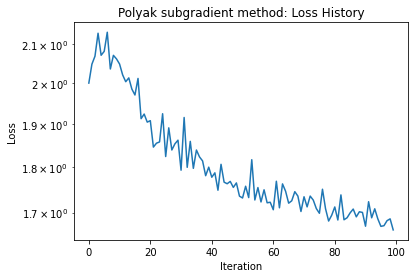

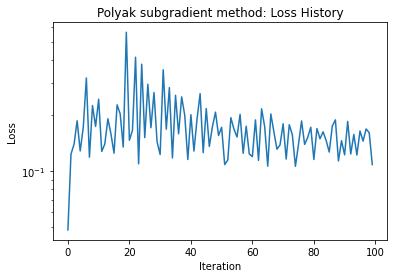

In [7]:

P_val = 600
h_params_polyak_unconstrained = torch.rand(P_val, dtype=torch.float64)
h_params_polyak_unconstrained.requires_grad = True

loss_f_softmax = unconstrained_loss(P_val)

if 'history_polyak_unconstrained_random' not in locals():
    history_polyak_unconstrained_random = {}
else:
    h_params_polyak.data = history_polyak_unconstrained_random['best_h_params'].data.clone()

max_iter = 100
target_loss = 1.52
print_every = 1000

history_polyak_unconstrained_random = polyak_subgradient_method(h_params_polyak_unconstrained, loss_f_softmax, max_iter, target_loss, print_every, history_polyak_unconstrained_random)

print("Best loss found:", history_polyak_unconstrained_random['min_loss_found'])

# semilogy plot of loss history
plt.semilogy(history_polyak_unconstrained_random['loss_history'])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Polyak subgradient method: Loss History")
plt.show()

plt.semilogy(history_polyak_unconstrained_random['grad_norm_history'])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Polyak subgradient method: Loss History")
plt.show()


## BFGS on unconstrained loss (with weak wolfe line search)
    


Iteration 0: loss = 1.9993057251, grad_norm = 0.0616981499, min_loss_found_bfgs = 1.9993057251
Best loss found: 1.9993057250976562


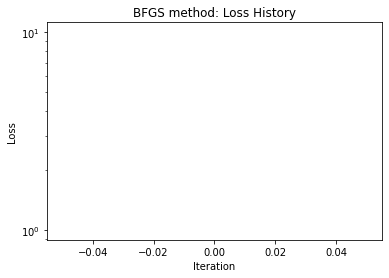

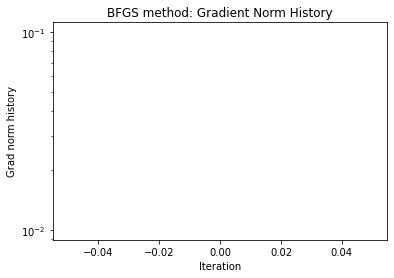

In [8]:
P_val = 600
h_params_bfgs_unconstrained = (torch.randn(P_val).abs() * 0.01 + 0.01).log()
# h_params_bfgs_unconstrained = h_params_google # Start from google's solution if you want.
# h_params_bfgs_unconstrained.data = torch.log(h_params_bfgs_unconstrained.data)
h_params_bfgs_unconstrained.requires_grad = True

loss_f_softmax = unconstrained_loss(P_val)

if 'history_bfgs_unconstrained_random' not in locals():
    history_bfgs_unconstrained_random = {}
else:
    h_params_bfgs_unconstrained.data = history_bfgs_unconstrained_random['best_h_params'].data.clone()

max_iter = 1
bfgs_params = {}
bfgs_params['lr'] = 1
bfgs_params['history_size'] = 2000
bfgs_params['ls_params'] = {'c1': 0.0001, 'c2': 0.9}
# bfgs_params['line_search_fn'] = None # no line search function. Will likely blow up.
bfgs_params['line_search_fn'] = 'weak_wolfe' # good for later iterations
print_every = 100

history_bfgs_unconstrained_random = bfgs_method(h_params_bfgs_unconstrained, loss_f_softmax, max_iter, bfgs_params, print_every, history_bfgs_unconstrained_random)

print("Best loss found:", history_bfgs_unconstrained_random['min_loss_found'])


# semilogy plot of loss history
plt.semilogy(history_bfgs_unconstrained_random['loss_history'])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("BFGS method: Loss History")
plt.show()

plt.semilogy(history_bfgs_unconstrained_random['grad_norm_history'])
plt.xlabel("Iteration")
plt.ylabel("Grad norm history")
plt.title("BFGS method: Gradient Norm History")
plt.show()

## NTD on unconstrained loss 

From https://github.com/COR-OPT/ntd.py

Starting NTD method: (Note each iteration gets more expensive as time goes on)
Iteration 0: loss = 2.0432036624, grad_norm = 0.1106948644, min_loss_found = 2.0432036624
Best loss found: 2.0432036623717957


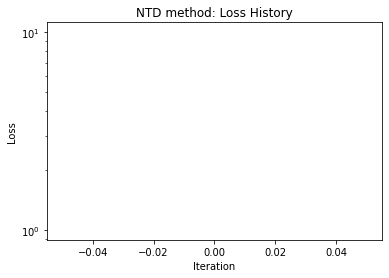

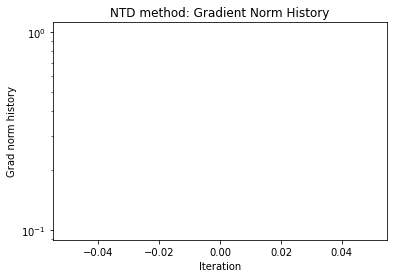

In [9]:
P_val = 600
h_params_ntd_unconstrained = torch.rand(P_val, dtype=torch.float64)
# h_params_ntd_unconstrained = h_params_google # Start from google's solution if you want.
h_params_ntd_unconstrained.data = torch.log(h_params_ntd_unconstrained.data)
h_params_ntd_unconstrained.requires_grad = True

loss_f_softmax = unconstrained_loss(P_val)

if 'history_ntd_unconstrained_random' not in locals():
    history_ntd_unconstrained_random = {}
else:
    h_params_ntd_unconstrained.data = history_ntd_unconstrained_random['best_h_params'].data.clone()

max_iter = 1
ntd_params = {}
ntd_params['adaptive_grid_size'] = True
ntd_params['verbose'] = False
ntd_params['max_grid_size'] = 15 # 50 
# ntd_params['opt_f'] = 1.5052
ntd_params['min_goldstein_iters'] = 1
ntd_params['use_trust_region'] = True
print_every = 1

history_ntd_unconstrained_random = ntd_method(h_params_ntd_unconstrained, loss_f_softmax, max_iter, ntd_params, print_every, history_ntd_unconstrained_random)

print("Best loss found:", history_ntd_unconstrained_random['min_loss_found'])

# semilogy plot of loss history
plt.semilogy(history_ntd_unconstrained_random['loss_history'])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("NTD method: Loss History")
plt.show()

plt.semilogy(history_ntd_unconstrained_random['grad_norm_history'])
plt.xlabel("Iteration")
plt.ylabel("Grad norm history")
plt.title("NTD method: Gradient Norm History")
plt.show()

# Prox linear method 

Basic idea: The objective function is a max of smooth function.

$$
L(h) = \max_{i} \ell_i(h)
$$

So we linearize them smooth function and then minimize the linearization over the constraint. In particular, given current iterate $h$, we solve:

$$
\begin{aligned}
h_+ = &\mathrm{argmin}_{h'} \max_{i} \{ \ell_i(h) + \nabla \ell_i(h) (h' - h) \} + \frac{\gamma}{2} \|h' - h\|^2\\
&\text{subject to }  h' \in \Delta_{2P}
\end{aligned}
$$

Note: 
- For large enough $\gamma$ (bigger than maximal lipschitz constant of gradient of $\ell_i$), each step is guaranteed to reduce the loss (if not at critical point), but progress is slower.
- For $\gamma = 0$, it takes bigs steps, good for initial iterates, but can start to cycle. 
- Lowest sol'n so far found is 1.5160777467, and i'm still running the method. It uses 1000 heights instead of 600.



In [ ]:
import os
P_val = 1000
h_params_prox_linear = torch.rand(P_val, dtype=torch.float64)
# h_params_prox_linear = h_params_google.detach().clone() # Start from google's solution if you want.
h_params_prox_linear.data = 1200*h_params_prox_linear.data/sum(h_params_prox_linear.data)
h_params_prox_linear.requires_grad = True
loss_fn = constrained_loss(P_val)

file_path = 'best_found_so_far_prox_linear.pt'
if os.path.exists(file_path):
    saved_best_h_params = torch.load(file_path)
    if 'history_prox_linear' not in locals():
        history_prox_linear = {}
        history_prox_linear['best_h_params'] = saved_best_h_params
        h_params_prox_linear.data = saved_best_h_params.data.clone()
    else:
        if loss_fn(saved_best_h_params) > (loss_fn(history_prox_linear['best_h_params'])):
            torch.save(history_prox_linear['best_h_params'], file_path)
            h_params_prox_linear.data = history_prox_linear['best_h_params'].data.clone()
            print("Current point better than point in file. Saving current point.")
        else:
            h_params_prox_linear.data = saved_best_h_params.data.clone()
            print("Point in file better than current point. Loading point in file.")
else:
    if 'history_prox_linear' not in locals():
        history_prox_linear = {}
    else: 
        torch.save(history_prox_linear['best_h_params'], file_path)
        h_params_prox_linear.data = history_prox_linear['best_h_params'].data.clone()
        print("No point in file. Saving current point.")

max_iter = 100 # try to run around 10-30 iterations at a time. can always pause and resume.
gamma_prox = .001 # initially set to zero, but then try .00001, .0001, .001, etc. set as low as possible while you still make progress.
print_every = 1
# Solver parameters. Seems like CLARABEL is better for this problem.
## For ECOS, Set error tolerances around 1e-9, then gradually decrease.
# prox_linear_params = {'solver' : 'ECOS', 'gamma_prox': gamma_prox, 'abstol': 1e-10, 'reltol': 1e-09, 'feastol': 1e-09, 'max_iters': 2000, 'verbose': False}
## Clarabel can handle much lower tolerances.
tol = 1e-17
prox_linear_params = {'solver' : 'CLARABEL', 'gamma_prox': gamma_prox, 'abstol': tol, 'reltol': tol, 'feastol': tol, 'max_iters': 2000, 'verbose': False}
history_prox_linear = prox_linear_method(h_params_prox_linear, loss_fn, print_every, max_iter, prox_linear_params, history_prox_linear)

print("Best loss found:", history_prox_linear['min_loss_found'])

# semilogy plot of loss history
plt.semilogy(history_prox_linear['loss_history'])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Proximal linear method: Loss History")
plt.show()

plt.semilogy(history_prox_linear['grad_norm_history'])
plt.xlabel("Iteration")
plt.ylabel("Grad norm history")
plt.title("Proximal linear method: Gradient Norm History")
plt.show()

file_path = 'best_found_so_far_prox_linear.pt'
torch.save(history_prox_linear['best_h_params'], file_path)
h_params_prox_linear.data = history_prox_linear['best_h_params'].data.clone()
print("No point in file. Saving current point.")

/var/folders/y5/4zrm18_56lzgk0gv8sz98s3w0000gn/T/ipykernel_93232/2022350479.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_best_h_params = torch.load(file_path)


Point in file better than current point. Loading point in file.
Iteration 0: loss = 1.5160005027, step_length = 0.0000001, grad_norm = 0.0743153, min_loss_found = 1.5160005027
Iteration 1: loss = 1.5160005027, step_length = 0.0000001, grad_norm = 0.0754521, min_loss_found = 1.5160005027
Iteration 2: loss = 1.5160005027, step_length = 0.0000008, grad_norm = 0.0618129, min_loss_found = 1.5160005027
Iteration 3: loss = 1.5160005027, step_length = 0.0000009, grad_norm = 0.0779996, min_loss_found = 1.5160005027
Iteration 4: loss = 1.5160005027, step_length = 0.0000065, grad_norm = 0.0628858, min_loss_found = 1.5160005027


KeyboardInterrupt: 

## LP solver from [Matolcsi and Vinuesa (2010)](https://www.sciencedirect.com/science/article/pii/S0022247X10006001)



In [ ]:
import os
P_val = 1000
h_params_lp = torch.rand(P_val, dtype=torch.float64)
# h_params_prox_linear = h_params_google.detach().clone() # Start from google's solution if you want.
h_params_lp.data = 1200*h_params_lp.data/sum(h_params_lp.data)
h_params_lp.requires_grad = True
loss_fn = constrained_loss(P_val)

if 'history_prox_linear' not in locals():
    history_prox_linear = {}
else:
    # if the file_path exists, load the best_h_params from it.
    file_path = 'best_found_so_far_lp.pt'
    if os.path.exists(file_path):
        saved_best_h_params = torch.load(file_path)
        if loss_fn(saved_best_h_params) > (history_lp['min_loss_found']):
            torch.save(history_lp['best_h_params'], file_path)
            h_params_lp.data = history_lp['best_h_params'].data.clone()
            print("Current point better than point in file. Saving current point.")
        else: 
            h_params_lp.data = saved_best_h_params.data.clone()
            print("Point in file better than current point. Loading point in file.")
    else:
        torch.save(history_lp['best_h_params'], file_path)
        h_params_lp.data = history_lp['best_h_params'].data.clone()
        print("No point in file. Saving current point.")
max_iter = 100 # try to run around 10-30 iterations at a time. can always pause and resume.
gamma_prox = .0001 # initially set to zero, but then try .00001, .0001, .001, etc. set as low as possible while you still make progress.
print_every = 1
# Solver parameters. Seems like CLARABEL is better for this problem.
## For ECOS, Set error tolerances around 1e-9, then gradually decrease.
# prox_linear_params = {'solver' : 'ECOS', 'gamma_prox': gamma_prox, 'abstol': 1e-10, 'reltol': 1e-09, 'feastol': 1e-09, 'max_iters': 2000, 'verbose': False}
## Clarabel can handle much lower tolerances.
tol = 1e-40
prox_linear_params = {'solver' : 'CLARABEL', 'gamma_prox': gamma_prox, 'abstol': tol, 'reltol': tol, 'feastol': tol, 'max_iters': 2000, 'verbose': False}
history_prox_linear = prox_linear_method(h_params_prox_linear, loss_fn, print_every, max_iter, prox_linear_params, history_prox_linear)

print("Best loss found:", history_prox_linear['min_loss_found'])

# semilogy plot of loss history
plt.semilogy(history_prox_linear['loss_history'])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Proximal linear method: Loss History")
plt.show()

plt.semilogy(history_prox_linear['grad_norm_history'])
plt.xlabel("Iteration")
plt.ylabel("Grad norm history")
plt.title("Proximal linear method: Gradient Norm History")
plt.show()

file_path = 'best_found_so_far_prox_linear.pt'
torch.save(history_prox_linear['best_h_params'], file_path)
h_params_prox_linear.data = history_prox_linear['best_h_params'].data.clone()
print("No point in file. Saving current point.")